In [1]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, model_selection
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts, parse_adata
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

import seaborn as sns
import math

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_visiumHD_subsampled.h5ad')
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
adata


AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [3]:
counts_mat = adata.layers['raw_count'].toarray()
coords_mat = adata.obsm['spatial']
gene_labels = adata.var_names

counts_mat.shape, coords_mat.shape, gene_labels.shape

((8509, 3058), (8509, 2), (3058,))

In [9]:
type(counts_mat), type(coords_mat), type(gene_labels)

(numpy.ndarray, numpy.ndarray, pandas.core.indexes.base.Index)

In [11]:
# GLM-PCA parameters
num_dims=8 # 2 * number of clusters
penalty=70 # may need to increase if this is too small

# CHANGE THESE PARAMETERS TO REDUCE RUNTIME
num_iters=30
eps=1e-4
num_genes=3058

counts_mat_glmpca=counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
glmpca_res=glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
                        ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

Iteration: 0 | deviance=3.7767E+7
Iteration: 1 | deviance=3.7767E+7
Iteration: 2 | deviance=3.6472E+7
Iteration: 3 | deviance=2.7597E+7
Iteration: 4 | deviance=2.7025E+7
Iteration: 5 | deviance=2.2776E+7
Iteration: 6 | deviance=2.1479E+7
Iteration: 7 | deviance=2.0713E+7
Iteration: 8 | deviance=2.0197E+7
Iteration: 9 | deviance=1.9818E+7
Iteration: 10 | deviance=1.9529E+7
Iteration: 11 | deviance=1.9302E+7
Iteration: 12 | deviance=1.9119E+7
Iteration: 13 | deviance=1.8969E+7
Iteration: 14 | deviance=1.8844E+7
Iteration: 15 | deviance=1.8739E+7
Iteration: 16 | deviance=1.8648E+7
Iteration: 17 | deviance=1.8569E+7
Iteration: 18 | deviance=1.8500E+7
Iteration: 19 | deviance=1.8438E+7
Iteration: 20 | deviance=1.8383E+7
Iteration: 21 | deviance=1.8334E+7
Iteration: 22 | deviance=1.8289E+7
Iteration: 23 | deviance=1.8249E+7
Iteration: 24 | deviance=1.8213E+7
Iteration: 25 | deviance=1.8180E+7
Iteration: 26 | deviance=1.8150E+7
Iteration: 27 | deviance=1.8122E+7
Iteration: 28 | deviance=1.809

In [12]:
outdir = '/ix/djishnu/shared/djishnu_kor11/gaston_outputs/mouse_kidney_13'
np.save(f'{outdir}/glmpca.npy', A)

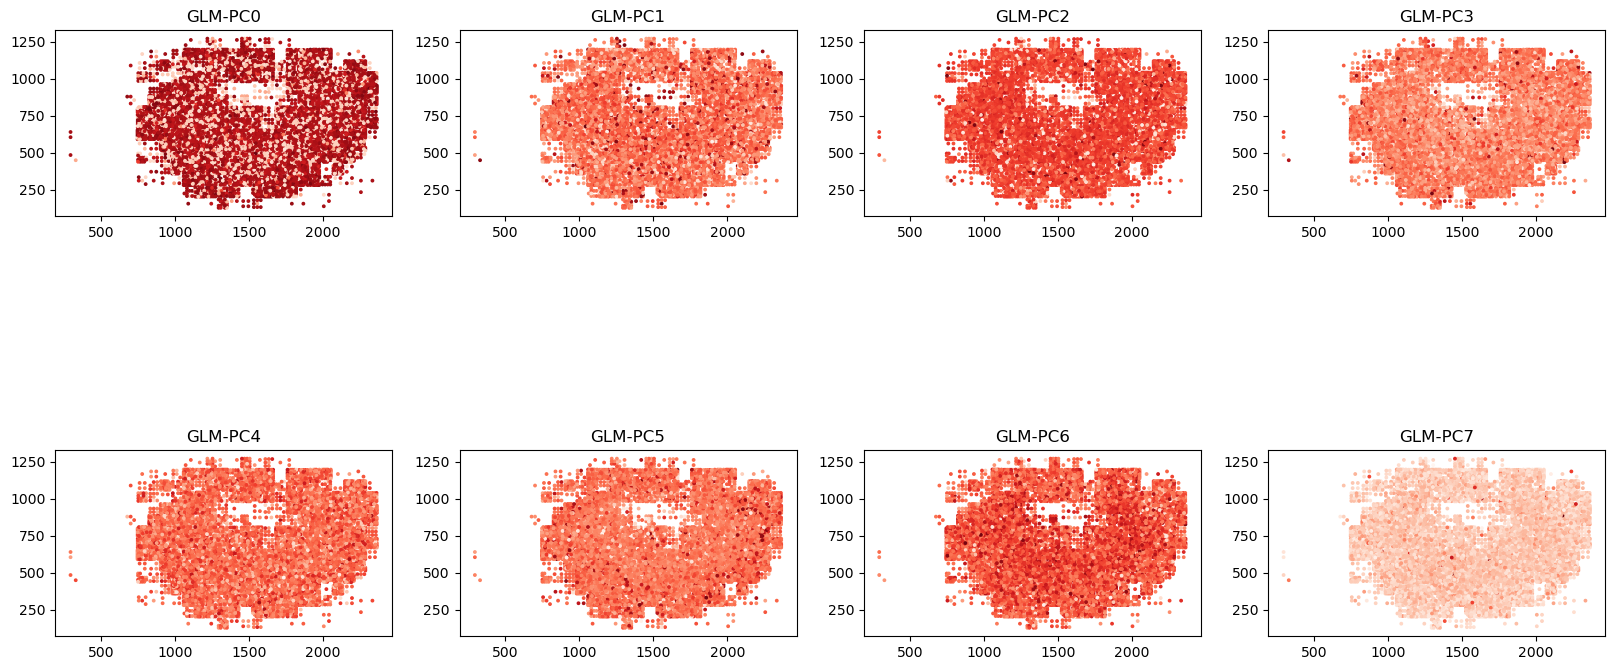

In [14]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')
        axs[r,c].set_aspect('equal')

In [4]:
# Load N x G matrix A of GLM-PCs, and N x 2 matrix S
# A=np.load('tutorial_outputs/glmpca.npy') # GLM-PCA results from above
outdir = '/ix/djishnu/shared/djishnu_kor11/gaston_outputs/mouse_kidney_13'

A=np.load(f'{outdir}/glmpca.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [6]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='/ix/djishnu/shared/djishnu_kor11/gaston_outputs/mouse_kidney_13' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 0
training neural network for seed 1
training neural network for seed 2
training neural network for seed 3
training neural network for seed 4
training neural network for seed 5
training neural network for seed 6
training neural network for seed 7
training neural network for seed 8
training neural network for seed 9
training neural network for seed 10
training neural network for seed 11
training neural network for seed 12
training neural network for seed 13
training neural network for seed 14
training neural network for seed 15
training neural network for seed 16
training neural network for seed 17
training neural network for seed 18
training neural network for seed 19
training neural network for seed 20
training neural network for seed 21
training neural network for seed 22
training neural network for seed 23
training neural network for seed 24
training neural network for seed 25
training neural network for seed 26
training neural network for seed 27
tr